In [1]:
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import StratifiedGroupKFold
from pandarallel import pandarallel
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
import massspecgym.utils as utils

In [2]:
df = pd.read_csv('../data/data/MassSpecGym.tsv', sep='\t')
df.head()

,mzs,intensities,smiles,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,identifier,collision_energy
0,"79.054138,81.07048,82.074127,91.051361,93.0693...","0.38100102145045966,0.3953013278855976,0.10929...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.169000,[M+H]+,284.161724,C15H24O5,C15H25O5,LC-ESI-QTOF,MassSpecGymID0000001,NaN
1,"71.056847,79.052544,80.058685,81.0382,81.06829...","0.06227883934890304,0.39419674451521586,0.0651...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.169000,[M+H]+,284.161724,C15H24O5,C15H25O5,LC-ESI-QTOF,MassSpecGymID0000002,NaN
2,"79.052597,83.050301,91.057404,217.120804","0.7272727272727273,0.8484848484848485,1.0,0.63...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.170000,[M+H]+,284.162724,C15H24O5,C15H25O5,LC-ESI-QTOF,MassSpecGymID0000003,NaN
3,"50.149521,50.251616,50.872388,51.607089,52.201...","0.01164719,0.01650368,0.01631492,0.01584310000...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,307.151581,[M+Na]+,284.162363,C15H24O5,C15H24NaO5,ESI-QFT,MassSpecGymID0000004,65HCD
4,"50.028968,50.261588,50.86206,51.129337,51.1694...","0.023949630000000003,0.017280439999999998,0.01...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,307.151581,[M+Na]+,284.162363,C15H24O5,C15H24NaO5,ESI-QFT,MassSpecGymID0000005,45HCD


### Prepare SMILES and pre-computed MCES distances

In [3]:
f = h5py.File('../data/all_smiles_standardized_mces/all_smiles_mces.hdf5', 'r')
print(list(f.keys()))
dists = squareform(f['mces'])
dists_smiles = f['mces_smiles_order'][:].astype(str).tolist()
dists.shape, len(dists_smiles)

['mces', 'mces_smiles_order']


((34731, 34731), 34731)

In [4]:
for s in df['smiles'].unique():
    assert s in dists_smiles

In [5]:
unique_smiles = df['smiles'].unique()
smiles_mask = np.array([s in unique_smiles for s in dists_smiles])
print(smiles_mask.shape[0], smiles_mask.sum(), len(unique_smiles))

dists = dists[smiles_mask, :][:, smiles_mask]
dists_smiles = np.array(dists_smiles)[smiles_mask]

from scipy.linalg import issymmetric
print(issymmetric(dists))

len(dists_smiles), dists.shape

34731 33681 33681
True


(33681, (33681, 33681))

### Perform agglomerative clustering using MCES distances

In [6]:
clustering = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    distance_threshold=10,
    n_clusters=None
).fit(dists)
clusters = clustering.labels_
pd.Series(clusters).value_counts()

86      21872
236       128
3826      104
207        94
480        91
        ...  
5324        1
5325        1
5326        1
5327        1
1297        1
Name: count, Length: 7703, dtype: int64

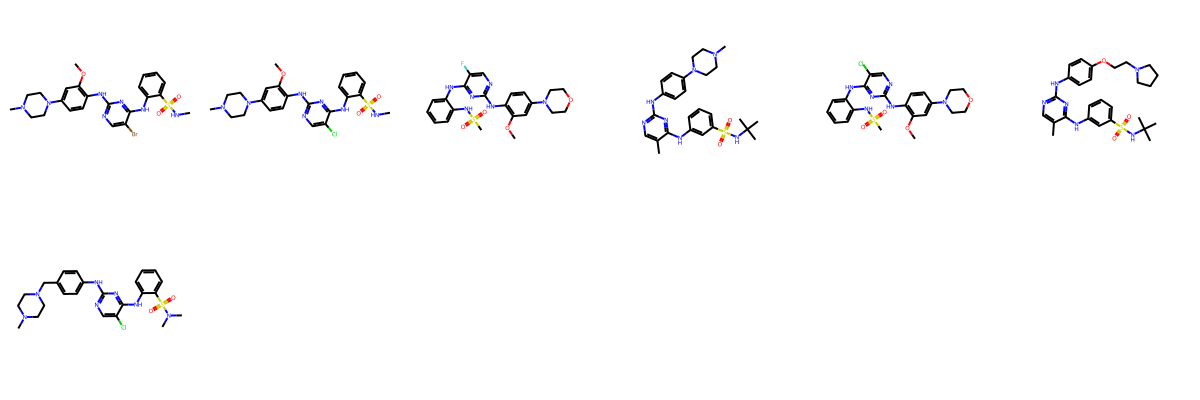

In [7]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in dists_smiles[np.where(clusters == 80)[0]]], molsPerRow=6, subImgSize=(200, 200))

### Define train-validation-test split

Compute metadata stratification groups

In [8]:
smiles_to_cluster = dict(zip(dists_smiles, clusters))
df['cluster'] = df['smiles'].map(smiles_to_cluster)

top_k_ces = df['collision_energy'].value_counts().index[:5]
smiles_vc = df['smiles'].value_counts()

def simple_ce(ce):
    if pd.isnull(ce):
        return 'none'
    if ce in top_k_ces:
        return ce
    return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c <= 5:
        return '(0, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def stratification_group(row):
    return str(row['adduct']) + \
        str(row['instrument_type']) + \
        str(simple_ce(row['collision_energy'])) + \
        str(simple_smiles_count(row['smiles']))
df['stratification_group'] = df.apply(stratification_group, axis=1)
df['stratification_group'].value_counts()

stratification_group
[M+H]+ESI-ITFTnone(5, 100]        63064
[M+Na]+ESI-ITFTnone(5, 100]       53603
[M+H]+ESI-ITFTnone(100, inf)      48686
[M+Na]+ESI-ITFTnone(100, inf)     47484
[M+H]+LC-ESI-QTOFother(5, 100]    16489
                                  ...  
[M+Na]+LC-ESI-ITFT10(100, inf)        1
[M+H]+ESI-FT60(0, 5]                  1
[M+Na]+LC-ESI-QFTnone(0, 5]           1
[M+H]+LC-Q-TOF/MS30(0, 5]             1
[M+H]+nan30(0, 5]                     1
Name: count, Length: 225, dtype: int64

Split with `StratifiedGroupKFold`

In [9]:
X = df['identifier'].values
y = df['stratification_group'].values
groups = df['cluster'].values
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)
folds = []
for i, (train_index, test_index) in enumerate(sgkf_split):
    print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
    folds.append(X[test_index])

/Users/roman/miniconda/envs/massspecgym/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


306877 (74.41 %)
52703 (12.78 %)
52822 (12.81 %)


In [10]:
X = df['identifier'].values
y = df['stratification_group'].values
groups = df['cluster'].values
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)
folds = []
for i, (train_index, test_index) in enumerate(sgkf_split):
    print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
    folds.append(X[test_index])

/Users/roman/miniconda/envs/massspecgym/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


306877 (74.41 %)
52703 (12.78 %)
52822 (12.81 %)


In [11]:
folds_map = {}
for i, fold in enumerate(folds):
    for identifier in fold:
        folds_map[identifier] = ['train', 'val', 'test'][i]
df['fold'] = df['identifier'].map(folds_map)
df.groupby(['fold']).agg({'smiles': 'nunique', 'identifier': 'nunique'})

,smiles,identifier
fold,,
test,5873,52822
train,21878,306877
val,5930,52703


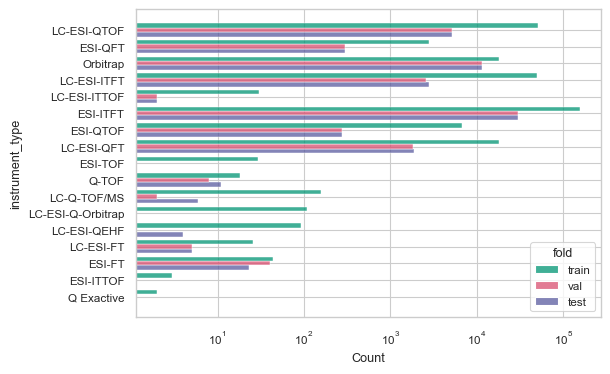

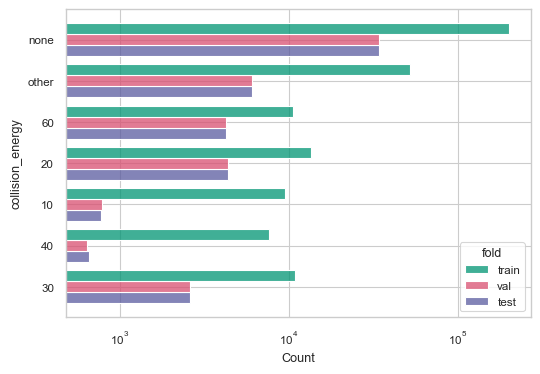

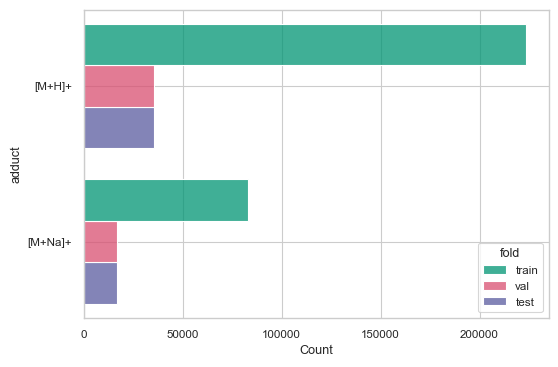

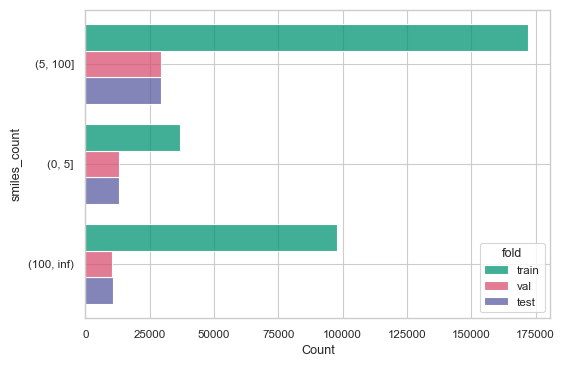

In [12]:
utils.init_plotting(figsize=(6, 4))
df_plot = df.copy()
df_plot['instrument_type'] = df_plot['instrument_type'].str.replace('Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'Q Exactive')
df_plot['collision_energy'] = df_plot['collision_energy'].apply(simple_ce)
df_plot['smiles_count'] = df_plot['smiles'].apply(simple_smiles_count)

sns.histplot(y='instrument_type', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
plt.xscale('log')
plt.show()

sns.histplot(y='collision_energy', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
plt.xscale('log')
plt.show()

sns.histplot(y='adduct', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
# plt.xscale('log')
plt.show()

sns.histplot(y='smiles_count', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
plt.show()

In [13]:
fps = {}
for fold in ['train', 'val', 'test']:
    df_fold = df[df['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: utils.morgan_fp(Chem.MolFromSmiles(s), to_np=False))
def max_train_tanimoto(test_fp, train_fps=fps['train']):
    return max([DataStructs.FingerprintSimilarity(test_fp, train_fp) for train_fp in train_fps])

100%|██████████| 5873/5873 [00:01<00:00, 4818.06it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


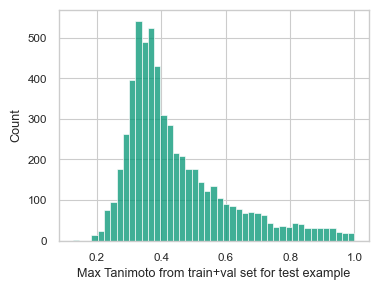

In [14]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['test'].parallel_apply(lambda f: max_train_tanimoto(f, pd.concat([fps['train'], fps['val']])))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train+val set for test example')
plt.show()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


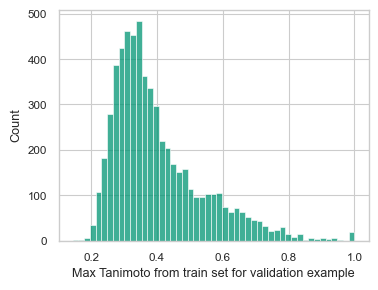

In [15]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['val'].parallel_apply(lambda f: max_train_tanimoto(f, fps['train']))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train set for validation example')
plt.show()

In [16]:
df = df.drop(columns=['cluster', 'stratification_group'])
df.to_csv('../data/data/MassSpecGym.tsv', sep='\t', index=False)